In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from scipy.signal import find_peaks
from scipy.interpolate import griddata
import pims
import trackpy as tp

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from utils.piv_utils import get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack
#construct_binned_velocity_maps

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# 1. Paths and Read-In
- 60fps might have to much flickering > increasing noise level for stationary pixels, try 24fps > DOESNT HELP


In [3]:
vid_path = "../data/videos/birdbath/vortex/"
vid_filename = "2024_0325_161529_030.MP4"
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename); print("vid properties: ", vid_props)
fps = vid_props[0]

# Scale D-high
pixel_per_real_width = .61
mpp = 1.65  # microns_per_pixel
print("D high - FHD, pixel_per_real_width = ", pixel_per_real_width)

# PIMs load in
frames_filepaths = f"../data/images/{vid_filename.split('.')[0]}/"
img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))
img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))

# Save figures
results_path = "../data/results/whirling/"
save_figure_path = os.path.join(results_path, vid_filename.split(".MP4")[0])
os.makedirs(save_figure_path, exist_ok=True)

xy_real_step = 300
xy_px_step = xy_real_step * mpp 

ax_params = {
    "xticks" : np.arange(0, img_width + xy_px_step, xy_px_step, dtype=int),
    "xticklabels" : np.arange(0, (img_width / mpp) + xy_real_step, xy_real_step, dtype=int)[::-1],
    "yticks" : np.arange(0, img_height, xy_px_step, dtype=int),
    "yticklabels" : np.arange(0, (img_height / mpp), xy_real_step, dtype=int),
    "xlabel" : "X (µm)", "ylabel" : "Y (µm)",
}

# Time-dependent selection of frames
time = np.linspace(0, len(frames) / fps, len(frames))  # in seconds
ttrigger = 30  # seconds
time_idx = np.where(time >= ttrigger)[0][0]
ttime = time[time_idx:]
num_frames = len(frames) - time_idx

print("selected time num_frames=", num_frames, "trigger time start-end", np.round(ttime[0]), np.round(ttime[-1]),"\n all frames", frames)

vid properties:  (60, 2420, 1920, 1080)
D high - FHD, pixel_per_real_width =  0.61
real width (µm):  1163.64 
real height (µm): 654.55
selected time num_frames= 620 trigger time start-end 30.0 40.0 
 all frames (ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0325_161529_030/*.jpg
    Length: 2420 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8


## Locate features for single frame

n features -  92
           y            x         mass      size       ecc     signal  \
0   5.900874  1544.004915   809.433082  2.319685  0.453783  44.207159   
1  27.921071  1591.268851   627.299587  2.318462  0.440837  32.492262   
2  37.562703  1201.201429   340.174089  1.699673  0.073605  25.198081   
3  37.796720  1683.313543   781.803608  2.689049  0.430879  36.912978   
4  42.064631  1226.763439  1056.772137  3.225279  0.104171  31.829155   

    raw_mass        ep  frame  
0 -9551.6561  1.243444   1800  
1 -9109.8821  0.920543   1800  
2 -8105.8627  0.578892   1800  
3 -7961.3985  0.549545   1800  
4 -4162.9607  0.235560   1800  


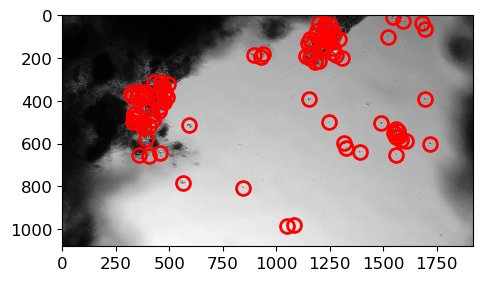

In [4]:
locate_params = {
    "diameter" : 13,
    "threshold" : 15, # 15
    "invert" : True
}
# Location of features
f = tp.locate(frames[time_idx], **locate_params)
print("n features - ", len(f))
print(f.head(5))

# Plot
plt.figure()
tp.annotate(f, frames[time_idx], plot_style={"markersize" : 10});

# 2. Batch Process frames

In [5]:
tp.quiet()
fbatch = tp.batch(frames[time_idx:], **locate_params)
print("n features from batch - ", len(fbatch))

n features from batch -  56620


# 3. Link particles / frames to trajectories

In [6]:
link_params = {
    "search_range" : 40,  # within ± N pixels, 55 previously
    "memory" : 3,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(fps/2); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 1312
30
N Before: 1312 
 N after filtering: 422


# 4. Trajectories
- Plot trajectories with associated particle number


/Users/mikehemberger/opt/miniconda3/lib/python3.9/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


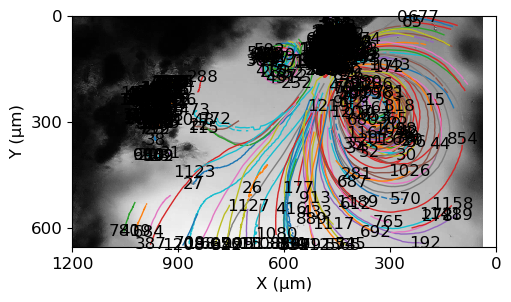

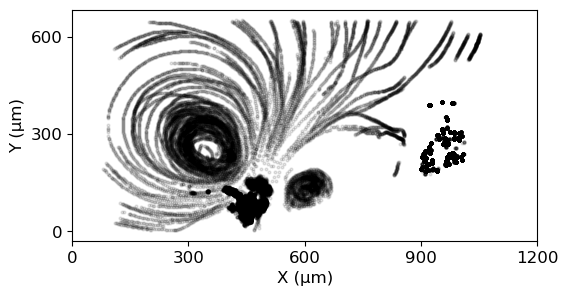

In [7]:
fig, ax = plt.subplots()
tp.plot_traj(trajs, superimpose=frames[time_idx], label=True, ax=ax); ax.set(**ax_params); 

fig, ax = plt.subplots()
tp.scatter(trajs, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k"});
ax.set(**ax_params); ax.invert_yaxis(); ax.invert_xaxis()

# Filter trajectories based on their statistics
- conditions here > low x- and y std, ie particle of trajectory is stationary

In [8]:
stats, frames_present = get_trajectory_stats(trajs);

# Spatial filtering of trajectories
to_drop = stats.loc[(stats["x_avg"] < 520) & (stats["y_avg"] < 720), "particle"].to_list()
trajs_ = trajs[~trajs['particle'].isin(to_drop)]

# Re-Calculate stats and reject more based on std of spatial position
stats, frames_present = get_trajectory_stats(trajs_);
reject_idx = (stats.x_std < 35) & (stats.y_std < 35)  #reject_idx = (stats.x_std < 20) | (stats.y_std < 20)
reject_prts = stats.particle[reject_idx].to_numpy()  #reject_prts = np.append(reject_prts, [56, 81]) 

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs_["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs_.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_filtered_particles = trajs_.particle.nunique()
num_particles = ctraj.particle.nunique()
num_particles_rejected = traj_rejected.particle.nunique()
print("number of particles (original):", num_ori_particles, "\nnumber of filtered particles:", num_filtered_particles,
      "\nnumber of rejected particles:", num_particles_rejected, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj)
print(len(stats))

number of particles = number of trajectories: 422
number of particles = number of trajectories: 280
number of particles (original): 422 
number of filtered particles: 280 
number of rejected particles: 149 
number of particles remaining: 131
number of particles = number of trajectories: 131
131


In [9]:
# stats, frames_present = get_trajectory_stats(trajs_);
# to_drop = stats.loc[(stats["x_avg"] < 1300) & (stats["x_avg"] > 1000) & (stats["y_avg"] < 250) & (stats["y_avg"] > 150), "particle"].to_list()
# to_drop
# fig, ax = plt.subplots(1,1,figsize=(20, 20))
# tp.plot_traj(ctraj, superimpose=frames[time_idx], label=True, ax=ax, plot_style={"lw" : .5});
# #ax.set(**ax_params); 
# ax.set(xlim=(1000,1300), ylim=(0,200))

## Visualize Trajectories
- after stats-based filtering, trajs should look better

/Users/mikehemberger/opt/miniconda3/lib/python3.9/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


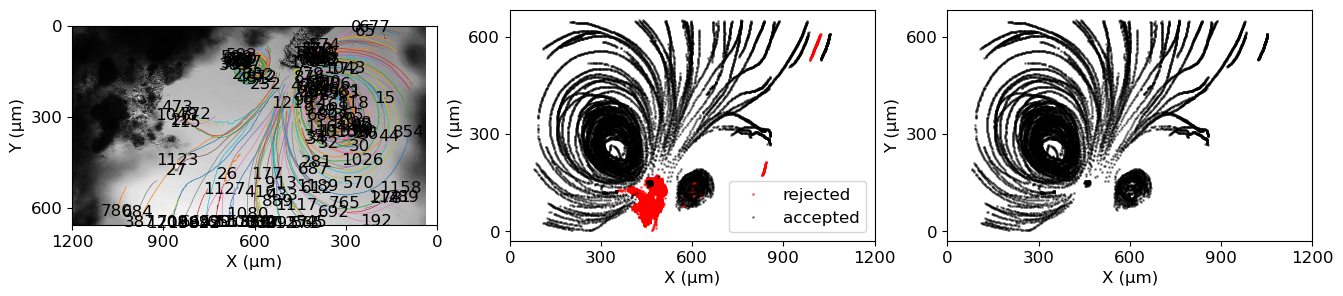

In [10]:
fig, ax = plt.subplots(1,3, figsize=(16, 3))
tp.plot_traj(ctraj, superimpose=frames[time_idx], label=True, ax=ax[0], plot_style={"lw" : .5}); ax[0].set(**ax_params); 

tp.scatter(traj_rejected, ax=ax[1], plot_style={"ms" : 1, "alpha" : .5, "color" : "r", "label" : "rejected"})
tp.scatter(ctraj, ax=ax[1], plot_style={"ms" : 1, "alpha" : .4, "color" : "k", "label" : "accepted"});
ax[1].set(**ax_params); ax[1].invert_yaxis(); ax[1].invert_xaxis(); ax[1].legend()

tp.scatter(ctraj, ax=ax[2], plot_style={"ms" : 1, "alpha" : .4, "color" : "k", "label" : "accepted"});
ax[2].set(**ax_params); ax[2].invert_yaxis(); ax[2].invert_xaxis()

# 2D map calculations

49.715122404933204

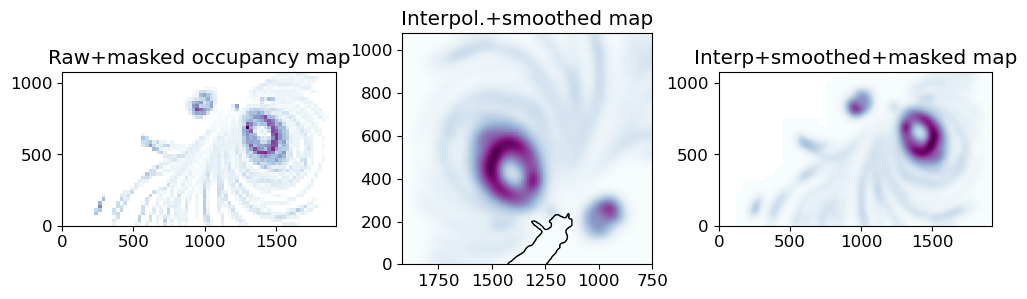

In [11]:
df = pd.DataFrame()
particles = ctraj.particle.unique()
for nth in particles:
    traj = ctraj.loc[ctraj["particle"] == nth]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    df_loop = pd.DataFrame(d)
    df = pd.concat([df, df_loop[1:]])

points = df[["x", "y"]].to_numpy()
velocities = df[["dx", "dy"]].to_numpy()
v_xy = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) * fps / mpp

bin_size_2d = 25
sigma_2d = 2
occupancy_map, x_edges, y_edges = construct_occupancy_map(points, img_height, img_width, bin_size_2d)
masked_occupancy_map = np.ma.masked_where(occupancy_map == 0, occupancy_map)
interpolated_omap, new_x_edges, new_y_edges = interpolate_2d_map(occupancy_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
masked_interpolated_map = np.ma.masked_where(interpolated_omap == 0, interpolated_omap)

cmap = plt.cm.BuPu
cmap.set_bad(color=(0, 0, 0, 0))  # Set color for masked values to be transparent

contour = np.squeeze(get_contours_from_segmasks(["../data/1800-2.png"])[0])

fig, ax = plt.subplots(1,3, figsize=(12, 3))
ax[0].imshow(masked_occupancy_map.T, extent=[0, img_width, 0, img_height], cmap=cmap, alpha=1)
ax[1].imshow(interpolated_omap.T, extent=[new_x_edges[0], new_x_edges[-1], new_y_edges[0], new_y_edges[-1]], origin='lower', cmap=cmap)
ax[1].plot(contour[:,0], contour[:,1], "-k", lw=1)
ax[1].set(xlim=(750, img_width)); ax[1].invert_xaxis()
ax[2].imshow(masked_interpolated_map.T, extent=[new_x_edges[0], new_x_edges[-1], new_y_edges[0], new_y_edges[-1]], cmap=cmap)
ax[0].set_title("Raw+masked occupancy map"); ax[1].set_title("Interpol.+smoothed map"); ax[2].set_title("Interp+smoothed+masked map");

np.max(interpolated_omap)

µm / sec: 318.07505482785547 525.6740357938709 0.0


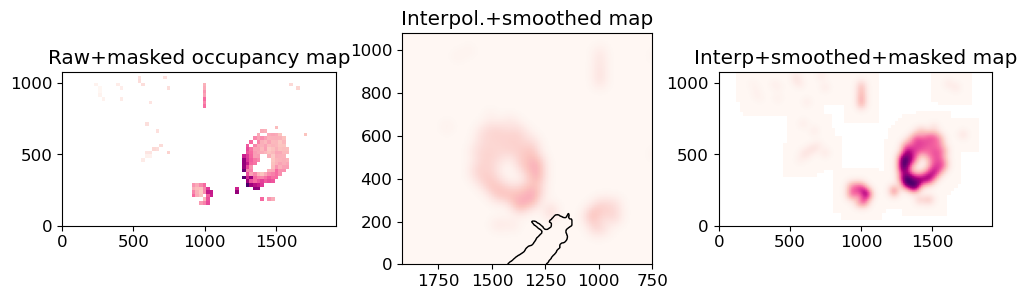

In [14]:
velocity_map, x_edges, y_edges = construct_velocity_map(points, v_xy, img_height, img_width, bin_size_2d)
masked_velocity_map = np.ma.masked_where(velocity_map == 0, velocity_map)
interpolated_vmap, new_x_edges, new_y_edges = interpolate_2d_map(velocity_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
masked_interpolated_vmap = np.ma.masked_where(interpolated_vmap == 0, interpolated_vmap)

cmap = plt.cm.RdPu#Reds#BuPu#Purples
cmap.set_bad(color=(0, 0, 0, 0)) 

fig, ax = plt.subplots(1,3, figsize=(12, 3))
ax[0].imshow(masked_velocity_map.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap)

ax[1].imshow(interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap, vmin=0, vmax=1000)
ax[1].plot(contour[:,0], contour[:,1], "-k", lw=1)
ax[1].set(xlim=(750, img_width)); ax[1].invert_xaxis()  # colorbar label >1mm/sec

ax[2].imshow(masked_interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap)
ax[0].set_title("Raw+masked occupancy map"); ax[1].set_title("Interpol.+smoothed map"); ax[2].set_title("Interp+smoothed+masked map")
print("µm / sec:", np.max(interpolated_vmap), np.max(velocity_map), np.min(interpolated_vmap))


In [15]:
# Define grid for velocity field for streamplines
step = 5
xbins = np.arange(0, img_width + step, step=step)
ybins = np.arange(0, img_height + step, step=step)
grid_x, grid_y = np.meshgrid(xbins, ybins)

# # Interpolate velocities onto grid
grid_u = griddata(points, velocities[:, 0] * fps / mpp, (grid_x, grid_y), method='linear')
grid_v = griddata(points, velocities[:, 1] * fps / mpp, (grid_x, grid_y), method='linear')
grid_vel = np.sqrt(grid_v ** 2 + grid_u ** 2)


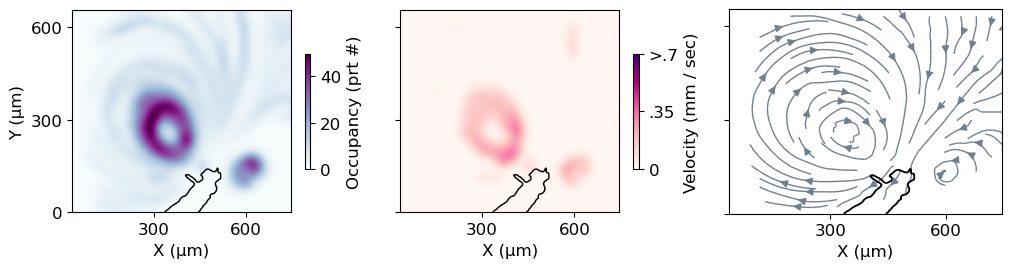

In [16]:
SAVE_FIGURES = False
xy_real_step = 300
xy_px_step = xy_real_step * mpp 

ax_params2 = {
    "xticks" : np.arange(0, img_width + xy_px_step, xy_px_step, dtype=int),
    "xticklabels" : np.arange(0, (img_width / mpp) + xy_real_step, xy_real_step, dtype=int)[::-1],
    "yticks" : np.arange(0, img_height, xy_px_step, dtype=int),
    "yticklabels" : np.arange(0, (img_height / mpp), xy_real_step, dtype=int),
    "xlabel" : "X (µm)", "ylabel" : "Y (µm)",
    "xlim" : (750, img_width),
}
    
cmap_v = plt.cm.RdPu
cmap_o = plt.cm.BuPu

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

omap = ax[0].imshow(interpolated_omap.T, extent=[new_x_edges[0], new_x_edges[-1], new_y_edges[0], new_y_edges[-1]], origin='lower', cmap=cmap_o)
ax[0].plot(contour[:,0], contour[:,1], "-k", lw=1)
fig.colorbar(omap, ax=ax[0], label="Occupancy (prt #)", shrink=.5)
ax[0].set(**ax_params2); ax[0].invert_xaxis()

ax_params2["yticklabels"] = []
vmap = ax[1].imshow(interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap_v, vmin=0, vmax=700)
cbar = fig.colorbar(vmap, ax=ax[1], label="Velocity (mm / sec)", shrink=.5, ticks=[0, 350, 700])
cbar.ax.set_yticklabels(["0", ".35", ">.7"])
ax[1].plot(contour[:,0], contour[:,1], "-k", lw=1)
ax[1].set(**ax_params2); ax[1].set_ylabel(""); ax[1].invert_xaxis()  # colorbar label >1mm/sec

ax[2].streamplot(grid_x, grid_y, grid_u, grid_v, color="slategrey", arrowsize=1.1, linewidth=1)
ax[2].plot(contour[:,0], contour[:,1], "-k", lw=1.25)
ax[2].set(**ax_params2); ax[2].set_ylabel(""); ax[2].invert_xaxis(); ax[2].set_aspect(.81)

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-2D-maps.jpg", dpi=600) if SAVE_FIGURES else None

-100.57749151555124 62.36461357390519
-22.628126651837576 19.29929729150782 -0.018263532857664952
-21.672025660715157 13.937704025845488 -0.026829927598875335


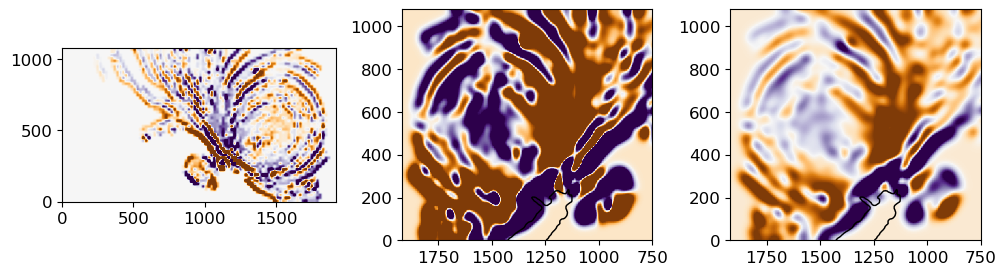

In [316]:

bin_size_2d = 20
sigma_2d = 2

vx_map, vy_map, x_edges, y_edges = construct_binned_velocity_maps(points, velocities * fps, img_height, img_width, bin_size_2d)
vx_map_, new_x_edges, new_y_edges = interpolate_2d_map(vx_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
vy_map_, new_x_edges, new_y_edges = interpolate_2d_map(vy_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
vorticity_map = calculate_vorticity_binned(vx_map, vy_map, x_edges, y_edges)
vorticity_map_ = calculate_vorticity_binned(vx_map_, vy_map_, new_x_edges, new_y_edges)
vorticity_map__, new_x_edges, new_y_edges = interpolate_2d_map(vorticity_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)

print(np.nanmin(vorticity_map), np.nanmax(vorticity_map))
print(np.nanmin(vorticity_map_), np.nanmax(vorticity_map_), np.nanmean(vorticity_map_))
print(np.nanmin(vorticity_map__), np.nanmax(vorticity_map__), np.nanmean(vorticity_map__))

fig, ax = plt.subplots(1,3, figsize=(12, 3))
ax[0].imshow(vorticity_map.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower', cmap='PuOr', vmin=-10, vmax=10)
ax[1].imshow(vorticity_map_.T, extent=[new_x_edges[0], new_x_edges[-1], new_y_edges[0], new_y_edges[-1]], origin='lower', cmap='PuOr_r', vmin=-2, vmax=1.5)
ax[1].plot(contour[:,0], contour[:,1], "-k", lw=1)
ax[1].set(xlim=(750, img_width)); ax[1].invert_xaxis()

ax[2].imshow(vorticity_map__.T, extent=[new_x_edges[0], new_x_edges[-1], new_y_edges[0], new_y_edges[-1]], origin='lower', cmap='PuOr_r', vmin=-5, vmax=4)
ax[2].plot(contour[:,0], contour[:,1], "-k", lw=1)
ax[2].set(xlim=(750, img_width)); ax[2].invert_xaxis()

In [ ]:
# import numpy as np

# def cartesian_to_polar(x, y):
#     r = np.sqrt(x**2 + y**2)
#     theta = np.arctan2(y, x)
#     return r, theta

# def radial_speed(x, y, vx, vy):
#     # Convert Cartesian coordinates to polar coordinates
#     r, theta = cartesian_to_polar(x, y)
#     # Calculate radial speed
#     v_radial = (x*vx + y*vy) / r    
#     return v_radial

# x = np.array([1, 2, 3])  # Example x coordinates
# y = np.array([4, 5, 6])  # Example y coordinates
# vx = np.array([0.1, 0.2, 0.3])  # Example x velocities
# vy = np.array([0.2, 0.3, 0.4])  # Example y velocities

# # Calculate radial speed for each particle
# v_radial = radial_speed(x, y, vx, vy)

# print("Radial speeds:", v_radial)


### Plot valid trajectories

{'xticks': [0, 960, 1920], 'xticklabels': ['1160', '580', '0'], 'yticks': array([  0, 495, 990]), 'yticklabels': array([  0, 300, 600]), 'xlabel': 'X (µm)', 'ylabel': 'Y (µm)'}


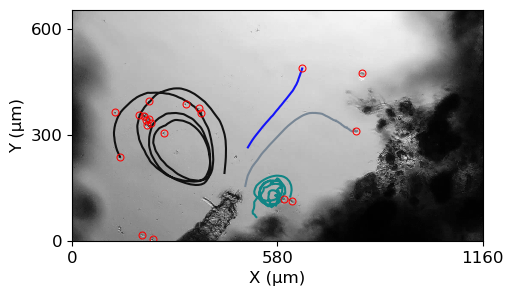

In [19]:

ax_params = {
    "xticks" : [0,int(img_width/2),img_width],#np.arange(img_width, 0, -xy_px_step, dtype=int),
    "xticklabels" : ["1160","580","0"],#np.arange((img_width / mpp), 0, -xy_real_step, dtype=int)[::-1],
    "yticks" : np.arange(0, img_height, xy_px_step, dtype=int),
    "yticklabels" : np.arange(0, (img_height / mpp), xy_real_step, dtype=int),
    "xlabel" : "X (µm)", "ylabel" : "Y (µm)",
}
print(ax_params)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
#tp.plot_traj(ctraj, superimpose=frames[time_idx], ax=ax, plot_style={"color": "k", "lw" : 1, "alpha" : .5});
ax.imshow(frames[time_idx], extent=[0, img_width, 0, img_height], cmap="gray")
#ax.plot([1275, 1425, 1425, 1275, 1275], [550, 550, 700, 700, 550], "--w", lw=1)

# traj plotting
particle_selected = [15,22,26,714]; lw_=1.5; al_ = .9;
ccolor = ["k", "slategray", "b", "teal"]
for ccol, sidx in zip(ccolor, particle_selected):
    ax.plot(ctraj.loc[ctraj.particle==sidx, "x"], ctraj.loc[ctraj.particle==sidx, "y"], "-", color=ccol, lw=lw_, alpha=al_)

# particle annotate, first frame
tp.annotate(ctraj[ctraj.frame == time_idx], frames[time_idx], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});  # this shows the bandpass filtered image

# axes stuff
ax.set(**ax_params);
ax.invert_yaxis(); ax.invert_xaxis()


# fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# #bbox = [1275, 1425, 550, 700]
# tp.annotate(ctraj[ctraj.frame == time_idx], frames[time_idx], ax=ax[1], plot_style={"markersize" : 25, "markeredgewidth" : 2});  # this shows the bandpass filtered image
# ax[1].set_xlim(1275, 1425); ax[1].set_ylim(550, 700); ax[1].invert_yaxis()
# ax[1].axis("off")

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-Image-frame-annotated-features-trajectories-overlayed.jpg", dpi=600) if SAVE_FIGURES else None

# Get a particle selection
- bring all particle trajs onto a common time axis and show as image > selection will become easy

9.158475272245556e-06 1.4484051808445393


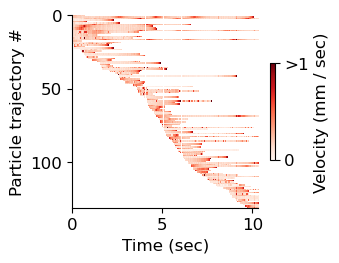

In [21]:
full_frames = np.arange(time_idx, len(frames))
displacement_array = reindex_calculate_displacement_and_stack(ctraj, full_frames)
displacement_array = (displacement_array / mpp * fps) / 1000
displacement_array[displacement_array==0.0] = np.nan

fr_time = (np.arange(time_idx, len(frames)) - time_idx) / fps
print(np.nanmin(displacement_array), np.nanmax(displacement_array))

fig, ax = plt.subplots(1, 1, figsize=(3,2.5))
cax = ax.imshow(displacement_array, aspect='auto', cmap="Reds", interpolation='none', vmin=0, vmax=1, extent=[0, fr_time[-1], displacement_array.shape[0], 0])
ax.set(xlabel="Time (sec)", ylabel="Particle trajectory #")
cbar = fig.colorbar(cax, label="Velocity (mm / sec)", shrink=.5); cbar.ax.set(yticks=(0,1), yticklabels=["0", ">1"]);
ax.spines[["top","right"]].set_visible(False)

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-PIV_trajectories-vs-time.jpg", dpi=600) if SAVE_FIGURES else None

In [31]:
displacement_array.shape
avg_max_vel = round(np.mean(np.nanmax(displacement_array, axis=1)),2)
std_max_vel = round(np.std(np.nanmax(displacement_array, axis=1)),2)
print(avg_max_vel, "±", std_max_vel)

0.74 ± 0.28


In [83]:
frame_count = ctraj.groupby("particle")["frame"].count()
(40/ mpp * fps) / 1000

1.4545454545454546

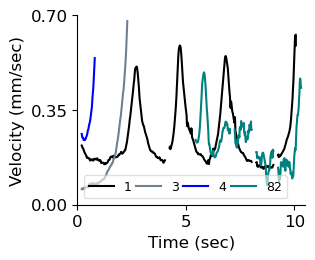

In [70]:
displacement_array = reindex_calculate_displacement_and_stack(ctraj, full_frames)
displacement_array = (displacement_array / mpp * fps) / 1000
df_disp = pd.DataFrame(displacement_array.T)
df_disp = df_disp.replace(0.0, np.nan)

selected_indices = [1,3,4,82]  # particles = [15,22,26,714]
prt_colors = ["k", "slategrey", "b", "teal"]

rwindow=12
fig, ax = plt.subplots(figsize=(3,2.5))
for pc, sidx in zip(prt_colors, selected_indices):
    ax.plot(fr_time, df_disp.iloc[:,sidx].rolling(window=rwindow).mean(), lw=1.5, color=pc, label=f"{sidx}");

plt.tight_layout(); 
ax.legend(fontsize=9, framealpha=.6, loc="lower left", ncols=4, columnspacing=.35, markerscale=.15);
ax.set(xlabel="Time (sec)", ylabel="Velocity (mm/sec)", ylim=(0, .7), yticks=[0, .35, .7], xlim=(0,10.5))
ax.spines[["top","right"]].set_visible(False)
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-PIV_selected-particles-velocity-vs-time.jpg", dpi=600) if SAVE_FIGURES else None

# plt.figure()
# plt.imshow(df_disp.iloc[:,:20].rolling(window=4).mean().T, aspect='auto', cmap="Reds", interpolation='none', vmin=0, vmax=.6, extent=[0, 600, 20, 0])

# get acceleration of those particles too!

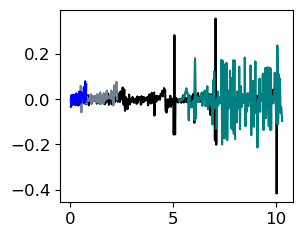

In [72]:
fig, ax = plt.subplots(figsize=(3,2.5))
for pc, sidx in zip(prt_colors, selected_indices):
    ax.plot(fr_time, df_disp.iloc[:,sidx].diff().rolling(window=2).mean(), lw=1.5, color=pc, label=f"{sidx}");

(0.05, 0.45)

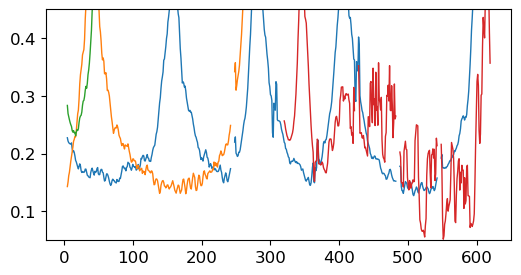

In [74]:
traj_idx = [1,7,4,82] # [82**,101] # potentially on the anti side # [1**,2,3,5,7**,9,10*,16] # mostly left and central
arr2 = df_disp.iloc[:,traj_idx].rolling(window=5).mean().to_numpy()
plt.figure(figsize=(6,3))
plt.plot(arr2, lw=1);
plt.ylim(.05,.45)

## Plot selected particles with time color code

- load Max/Min Z projection of all Frames

In [353]:
zproj_min = np.load("../data/results/vortex/trajectories_zmin-proj-tpoint2.npy")
# zproj_norm = (zproj_min) / (zproj_min.min() * -1)
# print(zproj_norm.min(), zproj_norm.max())
# fig, ax = plt.subplots(1,2,figsize=(17, 4))
# ax[0].imshow(zproj_norm, cmap="gray")
# ax[1].imshow(zproj_min, cmap="gray")

# for velocity > random selection of particles

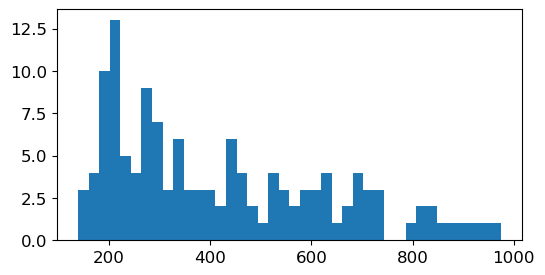

In [605]:
indices = stats.travel_dist.sort_values(ascending=False)[:10].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())
selected_prts
particles = ctraj.particle.unique()
dsize=[]
for nth, pt in enumerate(particles):  # selected_prts
    straj = ctraj.loc[ctraj["particle"] == pt]
    dsize.append(tp.diagonal_size(straj))

plt.hist(dsize, bins=40);

ValueError: DataFrame of trajectories is empty.

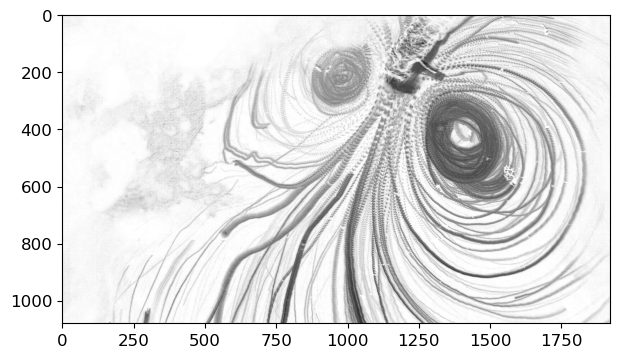

In [587]:
center_x_line = [1320, 730]
center_y_line = [0, img_height]
x_line = [700, img_width]
y_line = [0, 680]

fig, ax = plt.subplots(figsize=(17, 4))
ax.imshow(zproj_min, cmap="gray")
# ax.plot(center_x_line, center_y_line, "-k", alpha=.8, lw=.5)
# ax.plot(x_line, y_line, "-k", alpha=.8, lw=.5)
ccmap = mpl.cm.brg
prts = [288,107,490, 285] # 7,18 prts = [90, 490, 285, 445]
for nth, pt in enumerate(prts):
    traj = ctraj.loc[ctraj["particle"] == pt]
    tp.plot_traj(traj, ax=ax, colorby="frame", cmap=ccmap, label=False, plot_style={"linewidths" : 2});

ax.set_xlim(500, img_width); ax.set_ylim(0, img_height)
ax.invert_yaxis()
#fig.savefig("../data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-frame.jpg", dpi=600)

### select continuous

In [357]:
is_continuous = list()
for nth, row in stats.iterrows():
    clist = row["frames_present"]
    if all(np.diff(clist)<=2): #any(np.diff(clist)>=2):
        is_continuous.append(nth)

len(is_continuous)

92

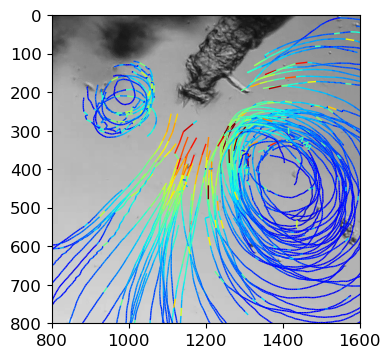

In [358]:
minmax = []
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(17,4))
ax.imshow(frames[time_idx], cmap="gray")
# or only continuous traj, w/o frame jump, or of different diag-size
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 35)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()

ax.set_xlim(800,1600); ax.set_ylim(0,800)
ax.invert_yaxis()
#fig.savefig("../data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement.jpg", dpi=600)

In [359]:
minmax_ = np.array(minmax)
minmax_.shape
print(minmax_.min(), minmax_.max())

0.0 38.05875473753428


### Position change
- loop through the points to color frames by velocity or global frame nr


In [ ]:
prts = [7,18,90,445,288,107,490, 285] # 7,18 prts = [90, 490, 285, 445]
# fig, ax = plt.subplots(len(prts), 1, figsize=(17,20))
# for nth, pt in enumerate(prts):
#     traj = ctraj.loc[ctraj["particle"] == pt]
#     xm = traj.x.diff().rolling(window=5).mean()
#     ym = traj.y.diff().rolling(window=5).mean()
#     dist = np.sqrt(xm ** 2 + ym ** 2)
#     tx = traj.frame.rolling(window=5).mean()

#     ax[nth].plot(tx, dist, "-b", label=f"particle {str(pt)}")
#     ax[nth].set_title(str(pt))
    
prts = [7, 107, 445]
prt_colors = ["k", "grey", "b"]
fig, ax = plt.subplots(figsize=(5,4))
prts = ctraj["particle"].unique()

for nth, pt in enumerate(prts):
    traj = ctraj.loc[ctraj["particle"] == pt]
    xm = traj.x.diff().rolling(window=5).mean()
    ym = traj.y.diff().rolling(window=5).mean()
    dist = (np.sqrt(xm ** 2 + ym ** 2) * .61) * 60 
    tx = traj.frame.rolling(window=5).mean()
    tx = (tx - 1800) / fps
    #ax.plot(tx, dist / 1000, "-", lw=2, color=prt_colors[nth], label=f"particle {str(pt)}")
    ax.plot(tx, dist / 1000, "-", lw=2, color="k", label=f"particle {str(pt)}")

ax.set_xlabel("Time (sec)"); ax.set_ylabel("Particle velocity (mm / sec)")
ax.set_ylim(0, 1.25)
#ax.legend()
plt.tight_layout()
#fig.savefig("../data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-displacement-timeseries.jpg", dpi=600)

IndexError: list index out of range

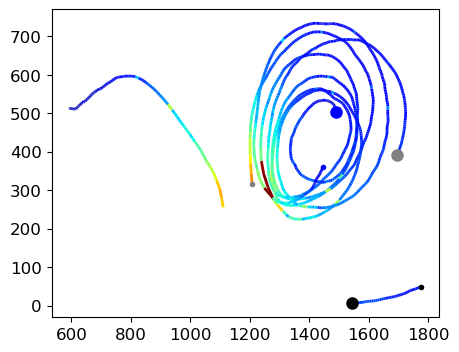

In [363]:
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(5,4))
for nth, pt in enumerate(prts):
    traj = ctraj.loc[ctraj["particle"] == pt]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 35)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=2, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()
        
        ax.plot(x[0], y[0], "o", ms=8, mec=prt_colors[nth], mfc=prt_colors[nth], label=f"particle {str(pt)}")
        ax.plot(x[-1], y[-1], "o", ms=3, mec=prt_colors[nth], mfc=prt_colors[nth])
        

ax.set_xlim(500, img_width); ax.set_ylim(0,img_height + 20)
ax.set_xlabel("x (px)"); ax.set_ylabel("y (px)")
ax.invert_yaxis()
plt.tight_layout()

#fig.savefig("../data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement-selected-only.jpg", dpi=600)

### trajectory params

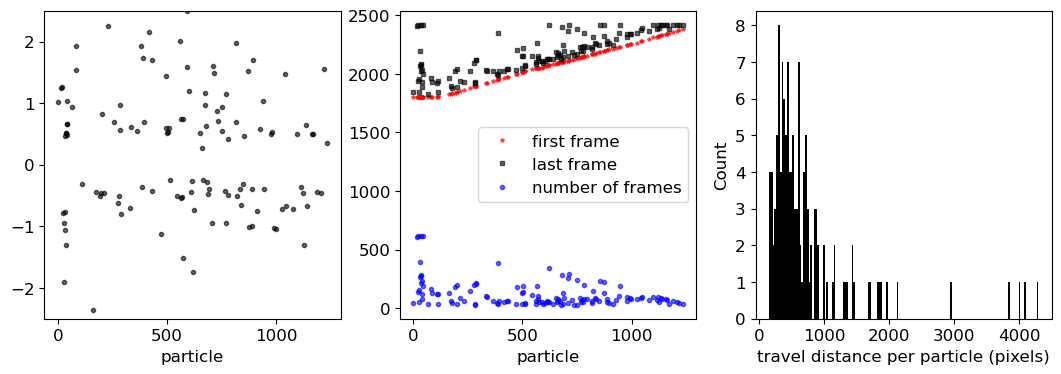

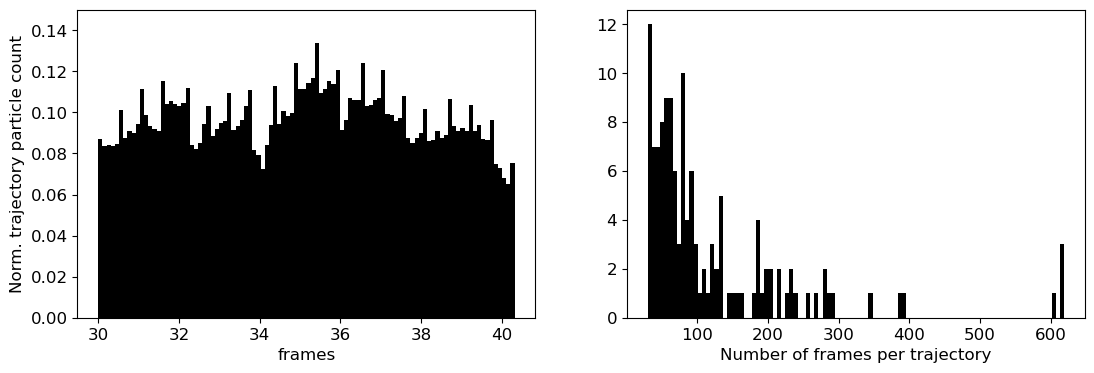

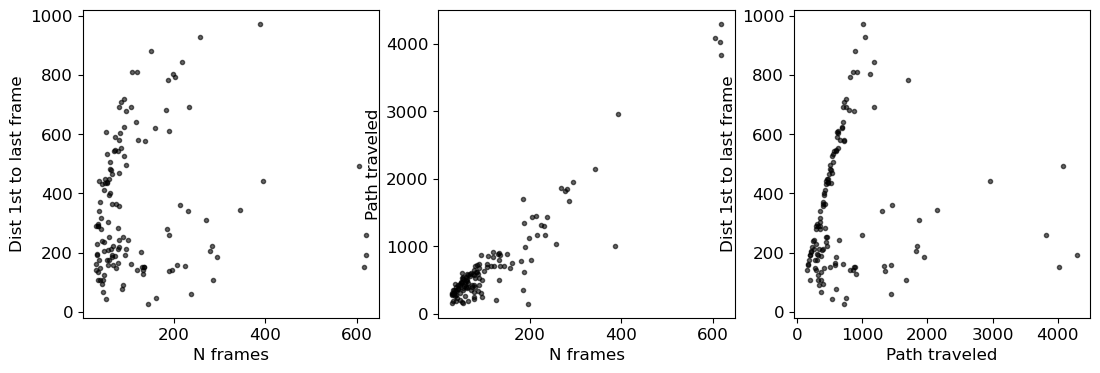

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.particle, stats.ep_median, ".k", alpha=.6)
ax[0].set_ylim(-2.5, 2.5); ax[0].set_xlabel("particle");

ax[1].plot(stats.particle, stats.first_frame, "*r", ms=3, alpha=.6, label="first frame")
ax[1].plot(stats.particle, stats.last_frame, "sk", ms=3, alpha=.6, label="last frame")
ax[1].plot(stats.particle, stats.nframes, "ob", ms=3, alpha=.6, label="number of frames")
ax[1].set_xlabel("particle");
ax[1].legend()

ax[2].hist(stats.travel_dist, bins=150, color="k");
ax[2].set_xlabel("travel distance per particle (pixels)");
ax[2].set_ylabel("Count"); #ax[2].set_xlim(0, 1500);


fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].hist(frames_present / 60, bins=100, density=True, color="k");
ax[0].set_xlabel("frames"); ax[0].set_ylabel("Norm. trajectory particle count");
ax[0].set_ylim(0, .15); #ax[0].set_xlim(0, 1050);


ax[1].hist(stats.nframes, bins=100, color="k");
ax[1].set_xlabel("Number of frames per trajectory")
#ax[1].set_xlim(0, 300);

fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.nframes, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[0].set_xlabel("N frames"); ax[0].set_ylabel("Dist 1st to last frame")

ax[1].plot(stats.nframes, stats.travel_dist, "ko", ms=3, alpha=.6)
ax[1].set_xlabel("N frames"); ax[1].set_ylabel("Path traveled")

ax[2].plot(stats.travel_dist, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[2].set_xlabel("Path traveled"); ax[2].set_ylabel("Dist 1st to last frame");

In [42]:
print(len(stats))
print(stats.nframes.min(), stats.nframes.max(), stats.nframes.mean(), stats.nframes.std(), "\n", np.percentile(stats.nframes, [25,50,75]))

131
30 619 121.52671755725191 117.22104879534716 
 [ 53.   79.  139.5]


In [43]:
np.corrcoef(stats.travel_dist, stats.displacement_first_last)

array([[1.        , 0.07857862],
       [0.07857862, 1.        ]])

In [44]:
np.corrcoef(stats.travel_dist, stats.nframes)

array([[1.        , 0.94162598],
       [0.94162598, 1.        ]])

29


0.8620689655172413

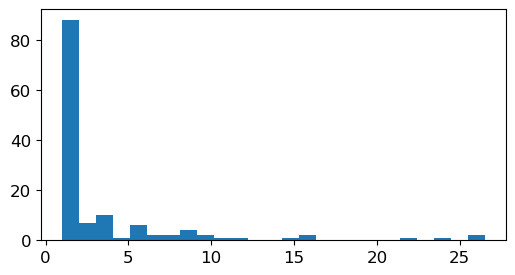

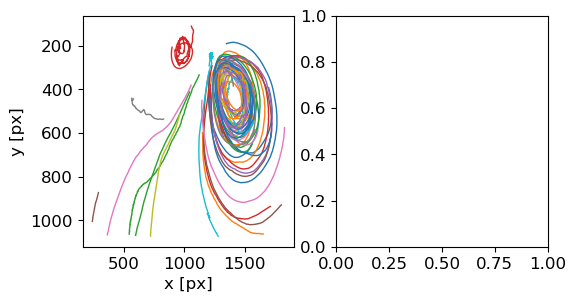

In [92]:
plt.hist(stats.travel_dist / stats.displacement_first_last, bins=25);
idx = np.where(stats.travel_dist / stats.displacement_first_last <= 1.1)[0]
idx = np.where(stats.nframes > 180)[0]; print(len(idx))
ratio_particles = stats.iloc[idx, 0].values
#not_particles = stats.iloc[~idx, 0].values
#print(not_particles)
fig, ax = plt.subplots(1,2)
for prt in ratio_particles:
    tp.plot_traj(ctraj[ctraj.particle==prt], ax=ax[0])
#for prt in not_particles:
#    tp.plot_traj(ctraj[ctraj.particle==prt], ax=ax[1])
1-4/29

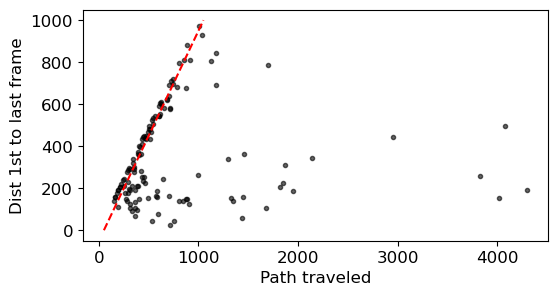

In [47]:
fig, ax = plt.subplots()
ax.plot(stats.travel_dist, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax.plot([0+50, 1000+50], [0, 1000],"--r")
ax.set_xlabel("Path traveled"); ax.set_ylabel("Dist 1st to last frame");

## Inspect all trajectories

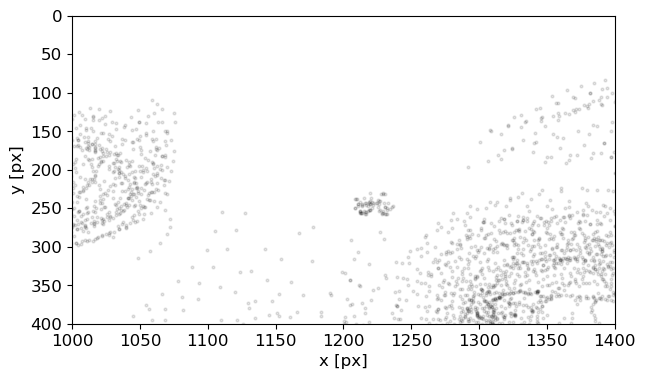

In [365]:
fig, ax = plt.subplots(figsize=(7, 4))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k"})
ax.set_xlim(1000, 1400); ax.set_ylim(0, 400)
ax.invert_yaxis()

## Trajectory selection

In [ ]:
# # RIGHT
# cxlim = [1300, 1800]
# cylim = [300, 1000]
# bool_idx_r = (stats.x_avg > cxlim[0]) & (stats.y_avg > cylim[0]) & (stats.nframes > 40) & (stats.nframes < 180)
# print(sum(bool_idx_r))
# stats.loc[bool_idx_r, :]
# selected_particle_trajs_r = sorted([28,90,243,244,400,490])
# bool_idx2_r = stats.particle.isin(selected_particle_trajs_r)
# right_selected = [90, 490] # 400, 
# #stats.loc[bool_idx2, :]
# yxlim = frames[0].shape
# ccmap = mpl.cm.brg

# prts = stats.loc[bool_idx2_r, "particle"]
# colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(prts))]

# fig, ax = plt.subplots(len(prts), 1, figsize=(7,50))
# for nth, pt in enumerate(prts):
#     traj = ctraj.loc[ctraj["particle"] == pt]
#     tp.plot_traj(traj, ax=ax[nth], colorby="frame", cmap=ccmap, label=False);
#     #ax[nth].set_xlim(cxlim); ax[nth].set_ylim(cylim)
#     ax[nth].set_title(str(pt))
#     ax[nth].invert_yaxis()



In [ ]:
# cxlim = [800, 1100]
# cylim = [0, 400]
# bool_idx = (stats.x_avg < cxlim[1]) & (stats.y_avg < cylim[1]) #& (stats.nframes > 40) & (stats.nframes < 80)
# print(sum(bool_idx))
# #stats.loc[bool_idx, :]
# selected_particle_trajs = sorted([445,386,354,285,191])
# bool_idx2 = stats.particle.isin(selected_particle_trajs)
# stats.loc[bool_idx2, :]

In [ ]:
# yxlim = frames[0].shape
# ccmap = mpl.cm.brg

# prts = stats.loc[bool_idx2, "particle"]
# left_selected = [285, 445]
# colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(prts))]

# fig, ax = plt.subplots(len(prts), 1, figsize=(7,20))
# for nth, pt in enumerate(prts):
#     traj = ctraj.loc[ctraj["particle"] == pt]
#     tp.plot_traj(traj, ax=ax[nth], colorby="frame", cmap=ccmap, label=False);
#     ax[nth].set_xlim(cxlim); ax[nth].set_ylim(cylim)
#     ax[nth].set_title(str(pt))
#     ax[nth].invert_yaxis()

## Single trajectory and Max/Min Z projection of Frames

In [366]:
indices = stats.travel_dist.sort_values(ascending=False)[:10].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())
selected_prts

[15, 20, 30, 32, 35, 36, 44, 145, 622, 714]

IndexError: index 0 is out of bounds for axis 0 with size 0

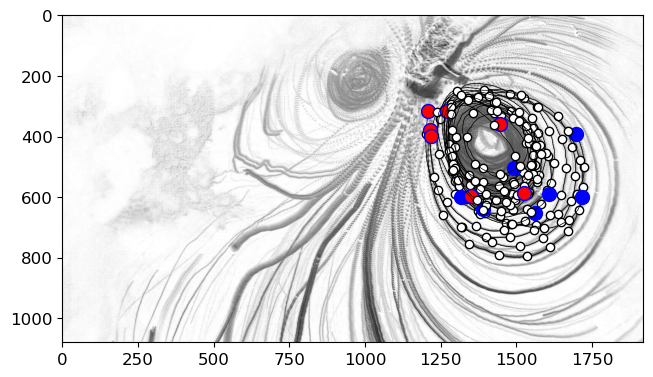

In [367]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.imshow(zproj_min, cmap="gray")

for prt in selected_prts:
    traj = ctraj.loc[ctraj["particle"] == prt] # 7,16
    prt_frames = traj["frame"].unique()
    x = traj.x.to_numpy()
    y = traj.y.to_numpy()
    
    ax.plot(x, y, "-k", lw=.5)
    ax.plot(x[::20], y[::20], "ok", mfc="w")
    ax.plot(x[0], y[0], "ob", mfc = "b", label="start", ms=10)
    ax.plot(x[-1], y[-1], "ob", mfc = "r", label="end", ms=10)
ax.set_xlim(500, 1800);

IndexError: index 0 is out of bounds for axis 0 with size 0

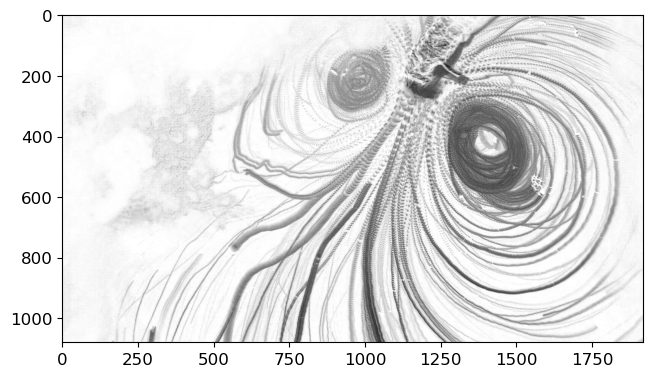

In [368]:
# have to do this with arrows, < and > do not cover it
traj = ctraj.loc[ctraj["particle"] == 354] # 7,16,9
prt_frames = traj["frame"].unique()
x = traj.x.to_numpy()
y = traj.y.to_numpy()

fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.imshow(zproj_min, cmap="gray")
ax.plot(x, y, "-k", lw=.5)
ax.plot(x[::20], y[::20], "ok", mfc="w")
ax.plot(x[0], y[0], "ob", mfc = "b", label="start", ms=10)
ax.plot(x[-1], y[-1], "ob", mfc = "r", label="end", ms=10)
ax.set_xlim(500, 1800); #ax.set_ylim(0, 700)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
tp.plot_traj(traj, superimpose=frames[frame_nr], ax=ax)
ax.plot(x, y, "--k")
ax.plot(x[0], y[0], ".r", label="start")
ax.plot(x[len(traj)-1], y[len(traj)-1], ".b", label="end")
ax.set_xlim(850, 1800); ax.set_ylim(0, 1000)
ax.legend()

In [ ]:
indices = stats.travel_dist.sort_values(ascending=False)[:20].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())

ccmap = mpl.cm.brg
yxlim = frames[0].shape
part_idx = selected_prts
colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(part_idx))]

fig, ax = plt.subplots(figsize=(10,4))
for nth, pt in enumerate(part_idx):
    traj = ctraj.loc[ctraj["particle"] == pt]
    if not traj.empty:
        #tp.plot_traj(traj, ax=ax, plot_style={"color": colors[nth]}, label=True);  # display {"linecolor": "k"}
        tp.plot_traj(traj, ax=ax, colorby="frame", cmap=ccmap, label=False);
ax.set_xlim(0, yxlim[1]); ax.set_ylim(0, yxlim[0])
ax.invert_yaxis()

In [ ]:
xy = ctraj.loc[ctraj["particle"] == 354, ["x", "y"]]
xy2 = ctraj.loc[ctraj["particle"] == 7, ["x", "y"]]

plt.figure(figsize=(4,3))
plt.plot(xy["x"], xy["y"], "-ok", lw=2, mfc="w", ms=3, label="354")
plt.plot(xy2["x"], xy2["y"], "-or", lw=2, mfc="w", ms=3, label="7")
plt.legend()
plt.gca().invert_yaxis()

plt.figure(figsize=(25,25))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=True); # , label=True, colorby="frame", plot_style={"set_xlim" : [1400, 1550]}

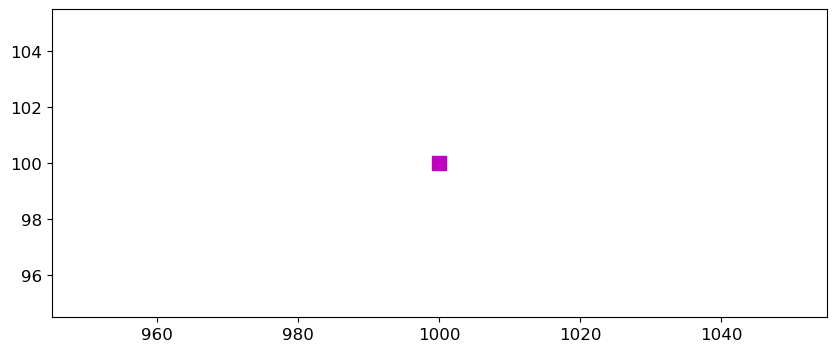

In [370]:

cmap = plt.cm.jet
part_idx = [9,7,354] # sorted([24,861, 646, 899, 207, 13,38,702, 578, 738, 912])
fig, ax = plt.subplots(figsize=(10,4))
#ax.set_facecolor('black')

for nth, pt in enumerate(part_idx):  # 13, 646, 912
    traj = ctraj.loc[ctraj["particle"] == pt]
    
    if not traj.empty:
        x, y = traj.x.to_numpy(), traj.y.to_numpy()
        dx, dy = traj.x.diff(), traj.y.diff()
        
        dist = np.sqrt(dx ** 2 + dy ** 2)
        vector = dist.to_numpy()[1:]
        norm = plt.Normalize(vector.min(), vector.max())
        
        # Create a LineCollection from the data
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()
        
        ax.plot(x[0], y[0], "ok", mfc="k", label="start")
        ax.plot(x[len(traj)-1], y[len(traj)-1], "o", mec="gray", mfc="gray", label="end")

ax.plot(1000, 100, "sm", mfc="m", ms=10, label="corona")


NameError: name 'yxlim' is not defined

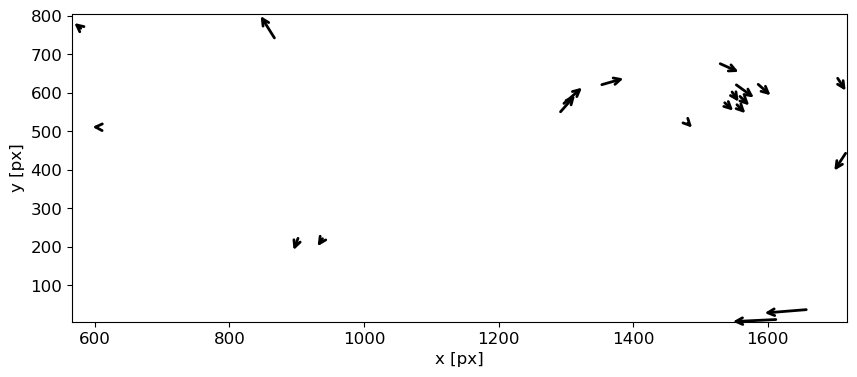

In [369]:
fig, ax = plt.subplots(figsize=(10,4))
tp.plot_displacements(ctraj, 1800, 1810, ax=ax);
ax.set_xlim(0, yxlim[1]); ax.set_ylim(0, yxlim[0])
ax.invert_yaxis()

In [ ]:
# VELOCITY FIELD FOR LATER 
# i = 0
# d = data[data.frame==i]
# plt.imshow(rawframes[i])
# plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
# plt.axis('off')